In this collab, we create a bipartite StellarGraph with two types of nodes: users and recipes and edges which represent the interactions between them. Later, we train a HINSage model for link prediction.  

In [ ]:
!pip install stellargraph

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

**Reading datasets**

In [ ]:
users = pd.read_csv("/content/drive/MyDrive/Food.com Recipes and Interactions/datasets/PP_users.csv")
recipes = pd.read_csv("/content/drive/MyDrive/Food.com Recipes and Interactions/datasets/PP_recipes.csv")
interactions = pd.read_csv("/content/drive/MyDrive/Food.com Recipes and Interactions/datasets/interactions_train.csv")

**Find unique users & recipes and give them appropriate indexes**

In [ ]:
users = interactions['u'].unique()
users = pd.DataFrame(users, columns=['u'])
users = users.set_index("user_"+users.index.astype(str))
users

,u
user_0,22095
user_1,24732
user_2,1674
user_3,20667
user_4,19047
...,...
user_25071,18127
user_25072,5201
user_25073,13311
user_25074,7790


In [ ]:
recipes = interactions['i'].unique()
recipes = pd.DataFrame(recipes, columns=["i"])
recipes = recipes.set_index('recipe_'+recipes.index.astype(str))
recipes 

,i
recipe_0,44367
recipe_1,87844
recipe_2,138181
recipe_3,93054
recipe_4,101723
...,...
recipe_160896,35126
recipe_160897,112580
recipe_160898,89109
recipe_160899,51525


In [ ]:
interactions

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723
...,...,...,...,...,...,...
698896,926904,457971,2018-12-18,5.0,13681,141067
698897,2002312797,27208,2018-12-18,5.0,14897,99787
698898,1290903,131607,2018-12-18,5.0,11605,76163
698899,226867,363072,2018-12-18,5.0,3604,29101


### **Generate edges**

In [ ]:
edges = pd.DataFrame(columns=['target', 'source', 'date'])
for index, row in interactions.iterrows():
  true_index_user = users.index[users['u'] == row['u']].tolist()
  true_index_recipe = recipes.index[recipes['i'] == row['i']].tolist() 
  edges.loc[index] = [true_index_user[0], true_index_recipe[0], row['date']]
edges

In [ ]:
edges.to_csv("/content/drive/MyDrive/food recipes/edges_final.csv")

In [ ]:
edges = pd.read_csv("/content/drive/MyDrive/Food.com Recipes and Interactions/edges_final.csv")

In [ ]:
edges.drop(['Unnamed: 0'], axis=1, inplace=True)
edges

,target,source,date
0,user_0,recipe_0,2000-02-25
1,user_0,recipe_1,2000-02-25
2,user_1,recipe_2,2000-03-13
3,user_1,recipe_3,2000-03-13
4,user_0,recipe_4,2000-04-07
...,...,...,...
698896,user_21665,recipe_142940,2018-12-18
698897,user_25075,recipe_2669,2018-12-18
698898,user_22591,recipe_49370,2018-12-18
698899,user_10668,recipe_134757,2018-12-18


In [ ]:
#since these edges exist in the graph, we give them weight of 1
edges['weight'] = 1
edges

,Unnamed: 0,target,source,date,weight
0,0,user_0,recipe_0,2000-02-25,1
1,1,user_0,recipe_1,2000-02-25,1
2,2,user_1,recipe_2,2000-03-13,1
3,3,user_1,recipe_3,2000-03-13,1
4,4,user_0,recipe_4,2000-04-07,1
...,...,...,...,...,...
698896,698896,user_21665,recipe_142940,2018-12-18,1
698897,698897,user_25075,recipe_2669,2018-12-18,1
698898,698898,user_22591,recipe_49370,2018-12-18,1
698899,698899,user_10668,recipe_134757,2018-12-18,1


**Create the graph**

The graph is created with two types of nodes (users and recipes) and edges - interaction between the nodes. The graph is bipartite.

In [ ]:
from stellargraph import StellarGraph

edges_graph = edges.drop(['date'], axis=1)
graph = StellarGraph({"users":users, "recipes":recipes}, edges_graph)
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 185977, Edges: 698901

 Node types:
  recipes: [160901]
    Features: float32 vector, length 1
    Edge types: recipes-default->users
  users: [25076]
    Features: float32 vector, length 1
    Edge types: users-default->recipes

 Edge types:
    recipes-default->users: [698901]
        Weights: all 1 (default)
        Features: float32 vector, length 1


In [ ]:
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_classification, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
batch_size = 200
epochs = 20

In [ ]:
#splitting all edges in 70:30
#70% of all edges is 489 230, but if we take first 10 years we have 499057 edges
edges_train = edges.loc[edges['date'] < '2010-01-01']
edges_train.drop(['date'], inplace=True, axis=1)
edges_train

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Unnamed: 0,target,source,weight
0,0,user_0,recipe_0,1
1,1,user_0,recipe_1,1
2,2,user_1,recipe_2,1
3,3,user_1,recipe_3,1
4,4,user_0,recipe_4,1
...,...,...,...,...
499052,499052,user_7046,recipe_123538,1
499053,499053,user_11070,recipe_111482,1
499054,499054,user_20032,recipe_46066,1
499055,499055,user_20946,recipe_4450,1


In [ ]:
#30% ~ 199844
edges_test = edges.loc[edges['date'] >= '2010-01-01']
edges_test.drop(['date'], inplace=True, axis=1)
edges_test

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Unnamed: 0,target,source,weight
499057,499057,user_20652,recipe_1002,1
499058,499058,user_13889,recipe_68675,1
499059,499059,user_20117,recipe_38343,1
499060,499060,user_9338,recipe_123765,1
499061,499061,user_14312,recipe_125805,1
...,...,...,...,...
698896,698896,user_21665,recipe_142940,1
698897,698897,user_25075,recipe_2669,1
698898,698898,user_22591,recipe_49370,1
698899,698899,user_10668,recipe_134757,1


**Generate random fake edges**

In order to balance the later model, we need to generate random fake edges which will have a weight of 0. These edges do not exist in the graph.
There are 400000 train false edges (499057 positive train edges) and 150000 test false edges (199844 positive test edges)



In [ ]:
import random

users_list = users.index.values.tolist()
recipes_list = recipes.index.values.tolist()

In [ ]:
edges_copy = edges[['target', 'source']]
edges_list = edges_copy.values.tolist()
edges_list

false_train = []

while(len(false_train) < 400000):
  user = random.choice(users_list)
  recipe = random.choice(recipes_list)
  if [user, recipe] not in edges_list:
      false_train.append([user,recipe])
    
false_train

In [ ]:
len(false_train)

In [ ]:
false_edges_train = pd.DataFrame(false_train, columns=['target', 'source'])
false_edges_train['weight'] = 0
false_edges_train

In [ ]:
false_test = []

while(len(false_test) < 150000):
  user = random.choice(users_list)
  recipe = random.choice(recipes_list)
  if [user, recipe] not in edges_list and [user,recipe] not in false_train:
      false_test.append([user,recipe])

false_test

In [ ]:
false_edges_test = pd.DataFrame(false_test, columns=['target', 'source'])
#these edges are false so we give them a weight of 0 since they don't really exist in the graph
false_edges_test['weight'] = 0
false_edges_test

**Concat the false edges with existent edges**

The model will take the edges as input, so we concatanate the false and positive edges.

In [ ]:
edges_final_train = edges_train.append(false_edges_train, ignore_index=True)
edges_final_train = edges_final_train.sample(frac=1) #include some shuffling
edges_final_train

In [ ]:
edges_final_test = edges_test.append(false_edges_test, ignore_index=True)
edges_final_test = edges_final_test.sample(frac=1) #include some shuffling
edges_final_test

In [ ]:
edges_final_train.to_csv("/content/drive/MyDrive/food recipes/edges_final_train.csv")
edges_final_test.to_csv("/content/drive/MyDrive/food recipes/edges_final_test.csv")

In [ ]:
edges_final_train = pd.read_csv("/content/drive/MyDrive/Food.com Recipes and Interactions/edges_final_train.csv")
edges_final_train.drop(['Unnamed: 0'], axis=1, inplace=True)
edges_final_train

,target,source,weight
0,user_8672,recipe_74566,1
1,user_5761,recipe_13475,0
2,user_23197,recipe_2198,0
3,user_12672,recipe_15521,1
4,user_1538,recipe_26611,1
...,...,...,...
699052,user_7822,recipe_151180,0
699053,user_14389,recipe_68639,0
699054,user_3636,recipe_48154,1
699055,user_13280,recipe_18810,1


In [ ]:
edges_final_test = pd.read_csv("/content/drive/MyDrive/Food.com Recipes and Interactions/edges_final_test.csv")
edges_final_test.drop(['Unnamed: 0'], axis=1, inplace=True)
edges_final_test

,target,source,weight
0,user_5673,recipe_37289,1
1,user_19768,recipe_83261,0
2,user_3286,recipe_92955,1
3,user_20915,recipe_158518,1
4,user_16054,recipe_121667,0
...,...,...,...
299839,user_16938,recipe_119447,1
299840,user_3919,recipe_34388,1
299841,user_8831,recipe_98283,0
299842,user_9338,recipe_35238,1


# **HINSAGE**

In [ ]:
labels_train = edges_final_train["weight"] #all 0 & 1
labels_test = edges_final_test["weight"]

In [ ]:
edges

,Unnamed: 0,target,source,date,weight
0,0,user_0,recipe_0,2000-02-25,1
1,1,user_0,recipe_1,2000-02-25,1
2,2,user_1,recipe_2,2000-03-13,1
3,3,user_1,recipe_3,2000-03-13,1
4,4,user_0,recipe_4,2000-04-07,1
...,...,...,...,...,...
698896,698896,user_21665,recipe_142940,2018-12-18,1
698897,698897,user_25075,recipe_2669,2018-12-18,1
698898,698898,user_22591,recipe_49370,2018-12-18,1
698899,698899,user_10668,recipe_134757,2018-12-18,1


In [ ]:
edgelist_train = list(edges_final_train[['target','source']].itertuples(index=False))
edgelist_test = list(edges_final_test[['target','source']].itertuples(index=False))

In [ ]:
num_samples = [8, 4]

In [ ]:
generator = HinSAGELinkGenerator(
    graph, batch_size, num_samples, head_node_types=["users", "recipes"]
)
train_gen = generator.flow(edgelist_train, labels_train, shuffle=True)
test_gen = generator.flow(edgelist_test, labels_test)

In [ ]:
generator.schema.schema

{'recipes': [EdgeType(n1='recipes', rel='default', n2='users')],
 'users': [EdgeType(n1='users', rel='default', n2='recipes')]}

In [ ]:
generator.schema.type_adjacency_list(generator.head_node_types, len(num_samples))

[('users', [2]),
 ('recipes', [3]),
 ('recipes', [4]),
 ('users', [5]),
 ('users', []),
 ('recipes', [])]

In [ ]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes, generator=generator, bias=True, dropout=0.0
)

In [ ]:
x_inp, x_out = hinsage.in_out_tensors()

In [ ]:
score_prediction = link_regression(edge_embedding_method="concat")(x_out)

link_regression: using 'concat' method to combine node embeddings into edge embeddings


In [ ]:
import tensorflow.keras.backend as K


def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))


model = Model(inputs=x_inp, outputs=score_prediction)
model.compile(
    optimizer=optimizers.Adam(lr=1e-2),
    loss=losses.mean_squared_error,
    metrics=[root_mean_square_error, metrics.mae],
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
num_workers = 4

In [ ]:
test_metrics = model.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

300/300 [==============================] - 53s 172ms/step - loss: 0.5909 - root_mean_square_error: 0.7683 - mean_absolute_error: 0.5817
Untrained model's Test Evaluation:
	loss: 0.5909
	root_mean_square_error: 0.7683
	mean_absolute_error: 0.5817


In [ ]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    workers=num_workers,
)

Epoch 1/20
3496/3496 [==============================] - 1139s 325ms/step - loss: 0.1245 - root_mean_square_error: 0.3519 - mean_absolute_error: 0.2789 - val_loss: 0.1337 - val_root_mean_square_error: 0.3651 - val_mean_absolute_error: 0.2851
Epoch 2/20
3496/3496 [==============================] - 1143s 327ms/step - loss: 0.1224 - root_mean_square_error: 0.3494 - mean_absolute_error: 0.2765 - val_loss: 0.1335 - val_root_mean_square_error: 0.3649 - val_mean_absolute_error: 0.2947
Epoch 3/20
3496/3496 [==============================] - 1193s 341ms/step - loss: 0.1224 - root_mean_square_error: 0.3494 - mean_absolute_error: 0.2770 - val_loss: 0.1325 - val_root_mean_square_error: 0.3637 - val_mean_absolute_error: 0.2992
Epoch 4/20
3496/3496 [==============================] - 1193s 341ms/step - loss: 0.1224 - root_mean_square_error: 0.3493 - mean_absolute_error: 0.2772 - val_loss: 0.1346 - val_root_mean_square_error: 0.3663 - val_mean_absolute_error: 0.2883
Epoch 5/20
3496/3496 [==============

# Results

In [ ]:
tf.keras.utils.custom_object_scope.

tensorflow.python.keras.utils.generic_utils.CustomObjectScope

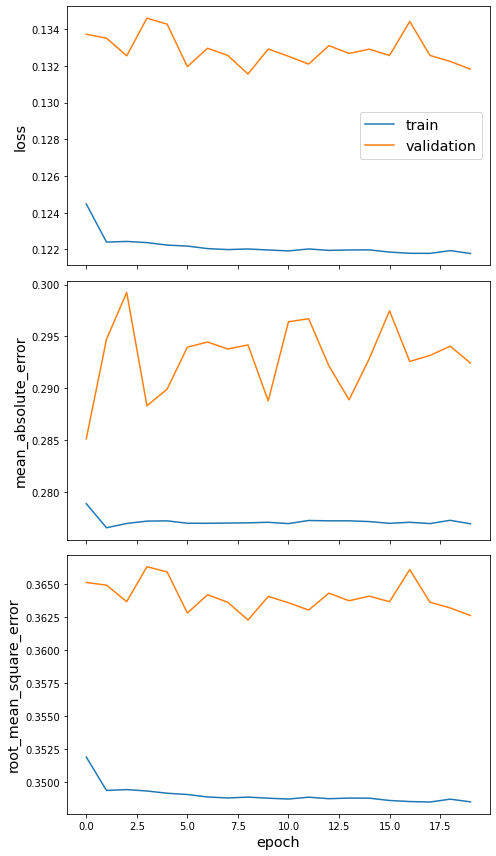

In [ ]:
sg.utils.plot_history(history)

In [ ]:
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1500/1500 [==============================] - 340s 226ms/step - loss: 0.1319 - root_mean_square_error: 0.3627 - mean_absolute_error: 0.2925
Test Evaluation:
	loss: 0.1319
	root_mean_square_error: 0.3627
	mean_absolute_error: 0.2925


In [ ]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = model.predict(test_gen)
y_pred2 = y_pred.round()
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, np.mean(y_true))

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  0.4714657993792982
	mean_absolute_error =  0.44456000201143386

Model Test set metrics:
	root_mean_square_error =  0.3631398244086344
	mean_absolute_error =  0.29252234708346686


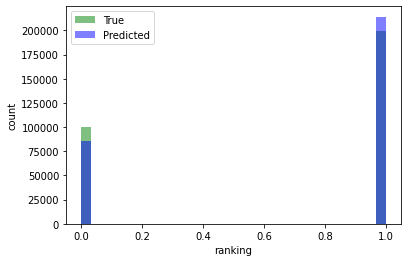

In [ ]:
h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred2, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

confusion_matrix(y_true, y_pred2)

array([[ 67128,  32872],
       [ 18616, 181228]])

In [ ]:
classification_report(y_true, y_pred2)

'              precision    recall  f1-score   support\n\n           0       0.78      0.67      0.72    100000\n           1       0.85      0.91      0.88    199844\n\n    accuracy                           0.83    299844\n   macro avg       0.81      0.79      0.80    299844\nweighted avg       0.83      0.83      0.82    299844\n'

accuracy of the model:  0.8282840410346713


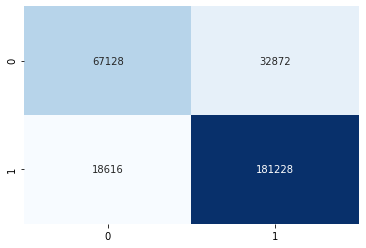

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred.round())
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",cbar=False)
#accuracy score
from sklearn.metrics import accuracy_score
ac=accuracy_score(y_true, y_pred.round())
print('accuracy of the model: ',ac)

In [ ]:
!mkdir -p saved_model
tf.keras.models.save_model(model, '/content/drive/MyDrive/Food.com Recipes and Interactions/hinsage_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food.com Recipes and Interactions/hinsage_model/assets


In [ ]:
import tensorflow as tf
from keras.models import load_model

tf.keras.utils.custom_object_scope 

model_loaded = tf.keras.models.load_model('/content/drive/MyDrive/Food.com Recipes and Interactions/hinsage_model')


In [ ]:
!pip install unet 



In [ ]:
model.save('/content/drive/MyDrive/Food.com Recipes and Interactions/model3')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food.com Recipes and Interactions/model3/assets


# Random predictions

In [ ]:
test_gen = generator.flow([('user_5673','recipe_37289')])

predictions = model.predict(test_gen)

In [ ]:
predictions.round()

array([[1.]], dtype=float32)

In [ ]:
test_gen = generator.flow([('user_19768','recipe_83261')])

predictions = model.predict(test_gen)
predictions.round()

array([[0.]], dtype=float32)

In [ ]:
test_gen = generator.flow([('user_0','recipe_0')])

predictions = model.predict(test_gen)
predictions.round()

array([[0.]], dtype=float32)

In [ ]:
test_gen = generator.flow([('user_10025','recipe_1887')])

predictions = model.predict(test_gen)
predictions.round()

array([[1.]], dtype=float32)

In [ ]:
test_gen = generator.flow([('user_5','recipe_1')])

predictions = model.predict(test_gen)
predictions.round()